# Displaying Scenes

A key feature of *scarlet* is operating with hyperspectral descriptions of celestial scenes. Color perception is thus critical to assessing the quality of the models. 
[Lupton et al. 2004](https://iopscience.iop.org/article/10.1086/382245) showed a consistent way of mapping three broad-band images onto RGB channels for visualization. The key is to normalize the image intensity, not each band, to preserve the color from the bright to the faint regions. Otherwise, the centers of bright objects all appear as white. 

We will often use the `arcsinh` function to normalize the intensities for objects with a wide range of fluxes:

$$f(x) = \frac{1}{Q} \sinh^{-1} \left( Q \frac{x-x_\textrm{min}}{\textrm{stretch}} \right)$$

where `Q` is the same as the $\beta$ softening parameter from [Lupton et al. 2004](https://iopscience.iop.org/article/10.1086/382245) and `stretch` determines the size of the linear region. This mapping is implemented in the [LSST software stack](https://github.com/lsst/afw/blob/master/python/lsst/afw/display/rgb/rgbContinued.py#L282-L321) and also in [astropy.visualization.make_lupton_rgb](http://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html#astropy.visualization.make_lupton_rgb).

The first step is thus to adjust the parameters `Q` and `stretch` such that the image brings out the features you want to show.

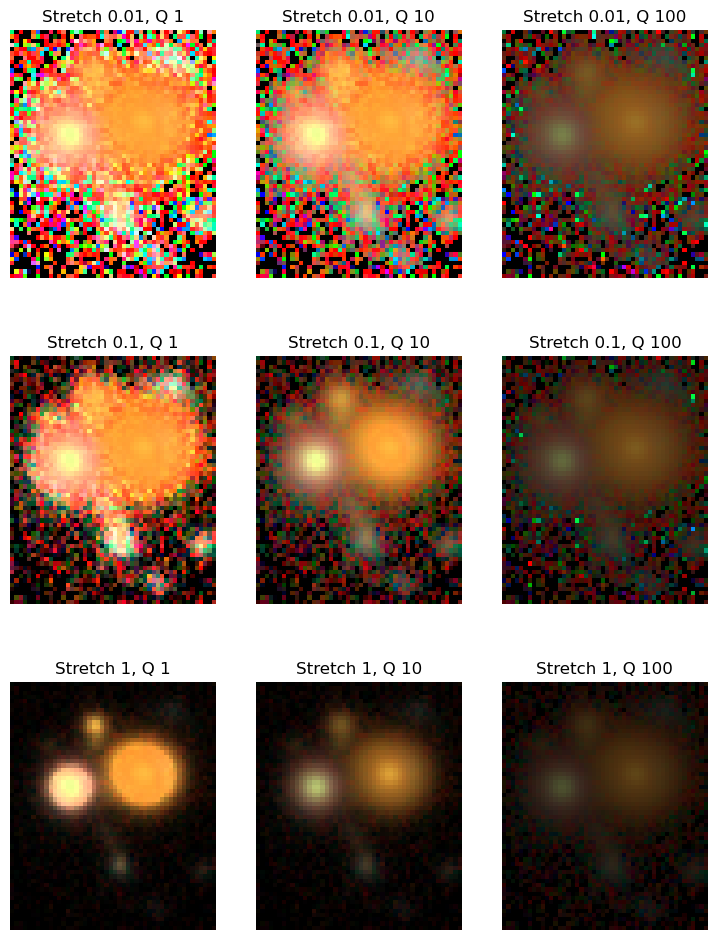

In [1]:
import numpy as np
import scarlet

%matplotlib inline
import matplotlib.pyplot as plt

# Load the sample images
data = np.load("../../data/hsc_cosmos_35.npz")
images = data["images"]
catalog = data["catalog"]
filters = data["filters"]
weights = 1/data["variance"]
psf = scarlet.ImagePSF(data["psfs"])

observation = scarlet.Observation(
    images, 
    psf=psf, 
    weights=weights, 
    channels=filters)

# Set the arcsinh color scaling object
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping

fig, ax = plt.subplots(3,3, figsize=(9,12))
for i, stretch in enumerate([0.01, 0.1, 1]):
    for j, Q in enumerate([1, 10, 100]):
        asinh = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
        # Scale the RGB channels for the image
        img_rgb = scarlet.display.img_to_rgb(images, norm=asinh)
        ax[i][j].imshow(img_rgb)
        ax[i][j].set_title("Stretch {}, Q {}".format(stretch, Q))
        ax[i][j].axis('off')

Values around `Q=10` and `stretch=0.1` look reasonable, so we will proceed with them.

In [2]:
norm =  AsinhMapping(minimum=0, stretch=0.1, Q=10)

Note that we set the minimum value to 0, which renders all negative values as black. This is reasonable for background-subtracted images, but may not be the right choice in all situations.

## Adjusting Filter Weights

*scarlet* adds the functionality of mapping images with *more* than three bands into RGB channels. The method `channels_to_rgb` we've implicitly used above takes a hyperspectral data cube or multiband image (with $C$ channels) as an input and converts it to RGB colors using the $3\times C$ linear mapping `channel_map`, and then normalizes the intensity in RGB space with the chosen norm.

Above, it used its default mapping (for 5 bands), which assumes the that bands are ordered from the shortest wavelength to the longest. We can have a look at the defaults:

In [3]:
import scarlet.display
print("Mapping from 1 band to RGB:\n", scarlet.display.channels_to_rgb(1))
print("Mapping from 3 bands to RGB:\n", scarlet.display.channels_to_rgb(3))
print("Mapping from 5 bands to RGB:\n", scarlet.display.channels_to_rgb(5))

Mapping from 1 band to RGB:
 [[1.]
 [1.]
 [1.]]
Mapping from 3 bands to RGB:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Mapping from 5 bands to RGB:
 [[0.         0.         0.         0.40011998 0.59988002]
 [0.         0.19976005 0.59988002 0.19976005 0.        ]
 [0.59988002 0.40011998 0.         0.         0.        ]]


We can see that the filter weights for a single band give equal weight to all three RGB channels, while the three-band case maps cleanly onto RGB channels. For more than three channels this mapping is not uniquely definable. This allows us to adjust the filter weights to e.g. visually isolate specific colors, reduce the impact of noise in a filter, or even mimic human perception.

Here we will adjust the filter weights to reduce the noise from the reddest Y band:

New channel map:
 [[0.         0.         0.2        0.5        0.3       ]
 [0.         0.19987995 0.6002401  0.19987995 0.        ]
 [0.59988002 0.40011998 0.         0.         0.        ]]


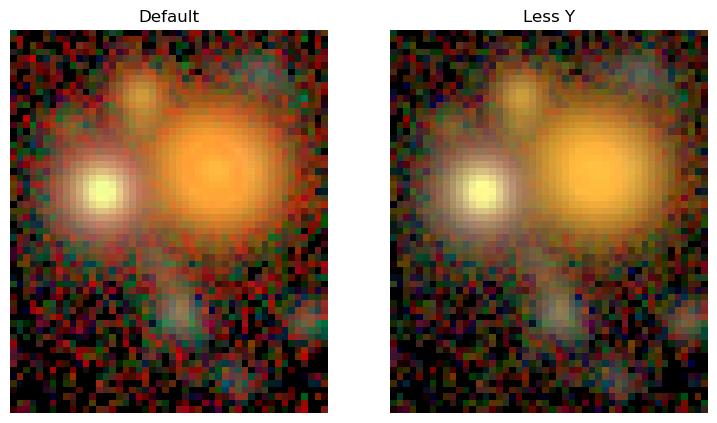

In [4]:
fig, ax = plt.subplots(1,2, figsize=(9,12))

img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
ax[0].imshow(img_rgb)
ax[0].set_title('Default')
ax[0].axis('off');

channel_map = scarlet.display.channels_to_rgb(5)
channel_map[0, :] = [0, 0, 0.2, 0.5, 0.3]
channel_map /= channel_map.sum(axis=1)[:,None]
print("New channel map:\n", channel_map)

img_rgb = scarlet.display.img_to_rgb(images, norm=norm, channel_map=channel_map)
ax[1].imshow(img_rgb)
ax[1].set_title('Less Y')
ax[1].axis('off');

## Display Model

Often we want to visually inspect the *scarlet* models and compare them to the observations. We provide two convenience functions in the `scarlet.display` module.

* `show_scene` combines all sources and renders the full scene
* `show_source` presents every source or every source component individually.

Let's demonstrate these methods with the model from the [Quick Start Tutorial](../0-quickstart.ipynb):

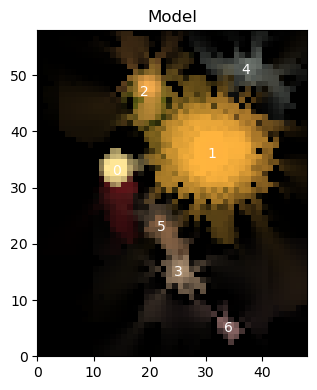

In [5]:
import pickle

fp = open("../hsc_cosmos_35.sca", "rb")
sources = pickle.load(fp)
fp.close()

scarlet.display.show_scene(sources, norm=norm, channel_map=channel_map)
plt.show()

Notice that we include the `plt.show()` at the end of the cell above. This is because `show_scene` returns the matplotlib `figure`, which is useful in cases where you might want to add annotations onto your plots, however without showing the scene or closing the figure the Jupyter notebook will display the figure twice.

To compare it to data, we need to provide the observation and make sure that the observed frame is matched to the model frame:

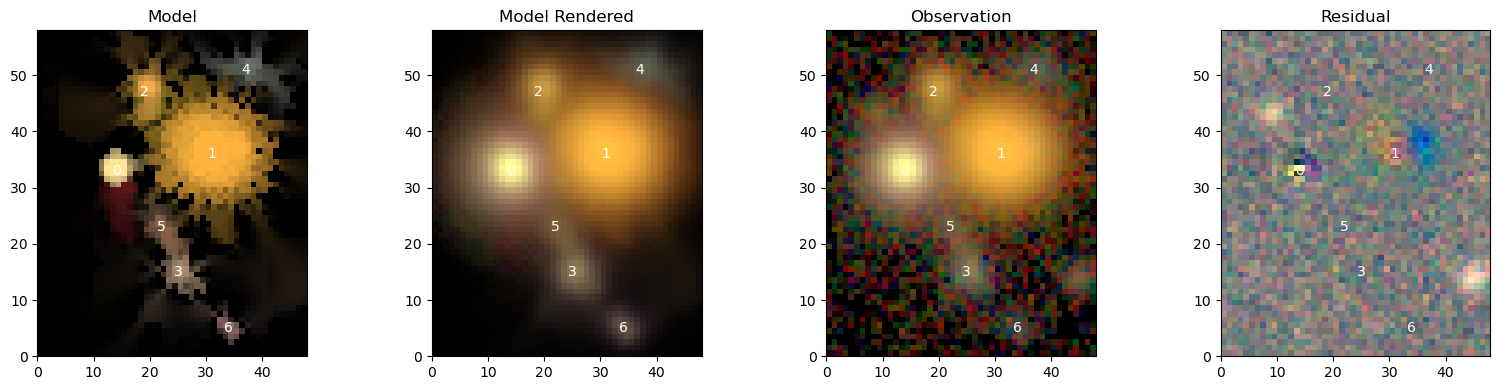

In [6]:
model_frame = sources[0].frame # any source carries the frame
observation = observation.match(model_frame)

scarlet.display.show_scene(sources, 
                           norm=norm, 
                           channel_map=channel_map, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True)
plt.show()

The same logic goes for the individual sources, with the option of also showing the spectra of the sources:

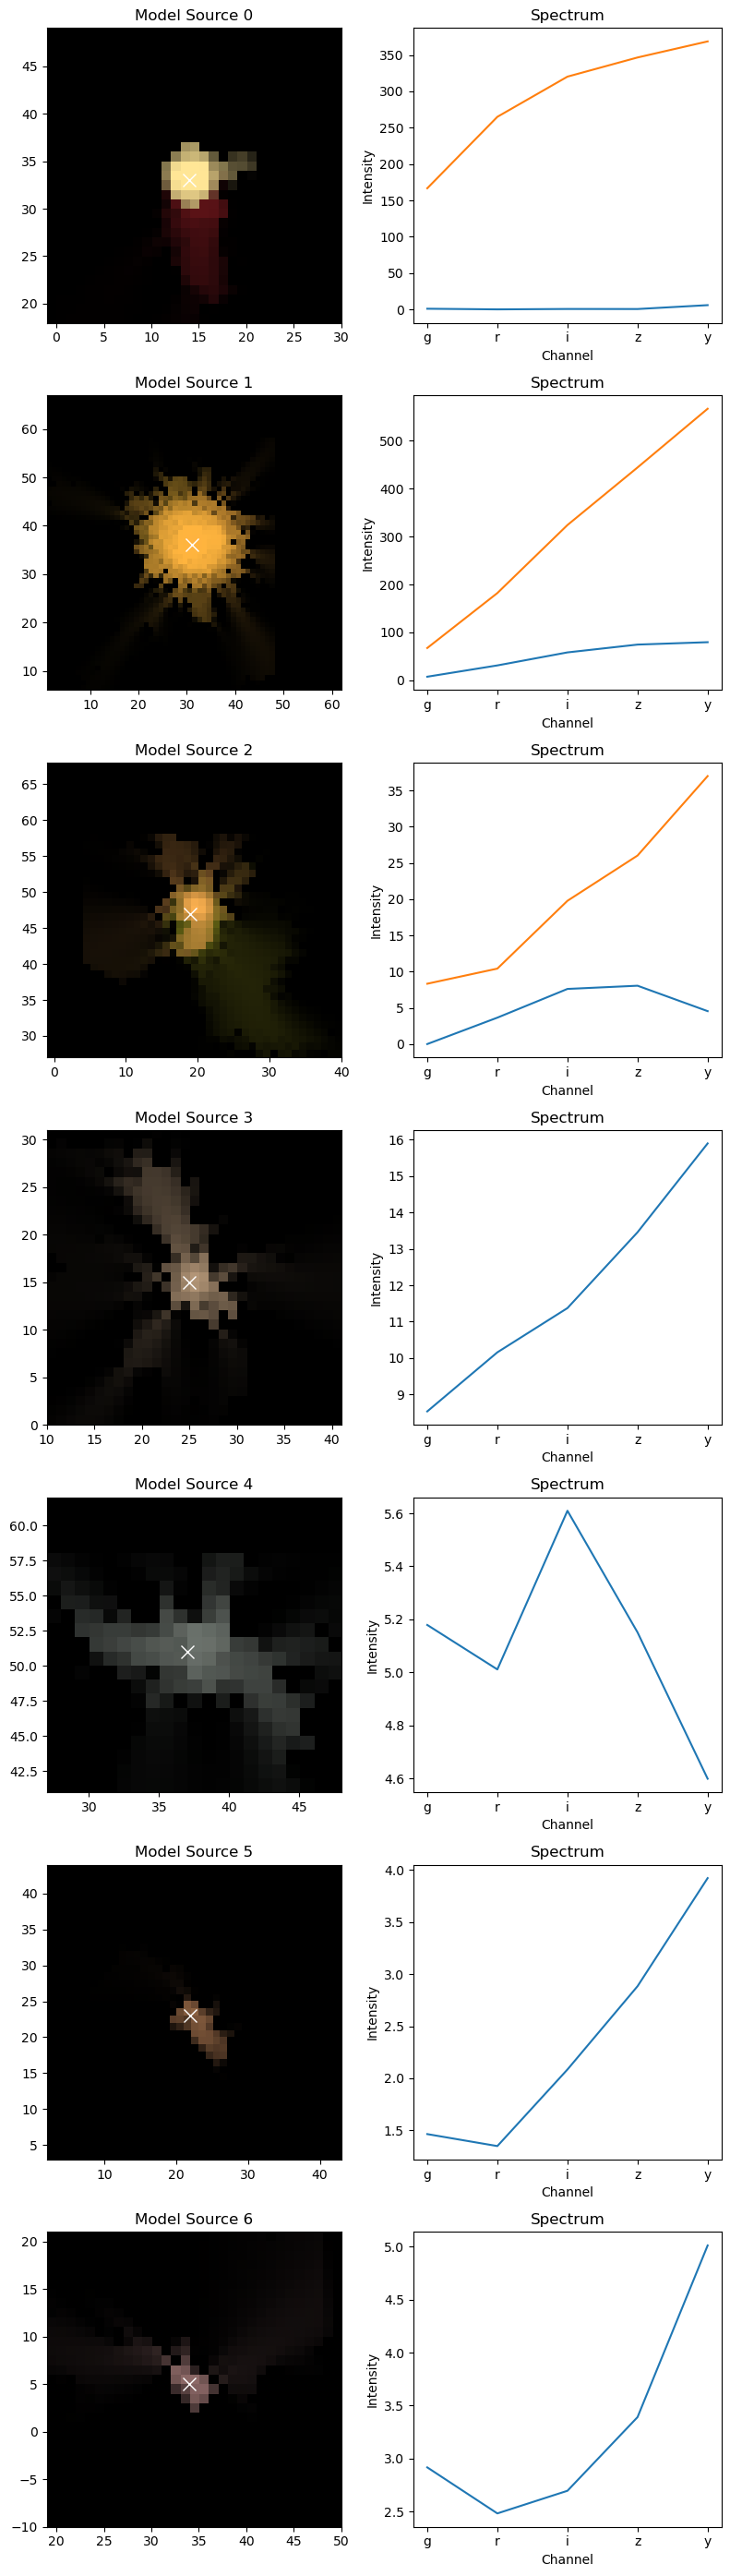

In [7]:
scarlet.display.show_sources(sources, norm=norm, channel_map=channel_map)
plt.show()

Source 1 is modelled with 2 components, and the spectra are shown for them separately. If we wanted to see the images of the components, we can just pass the source itself to `show_sources`. For good measure, we also switch on the rendering and the observation at the same location:

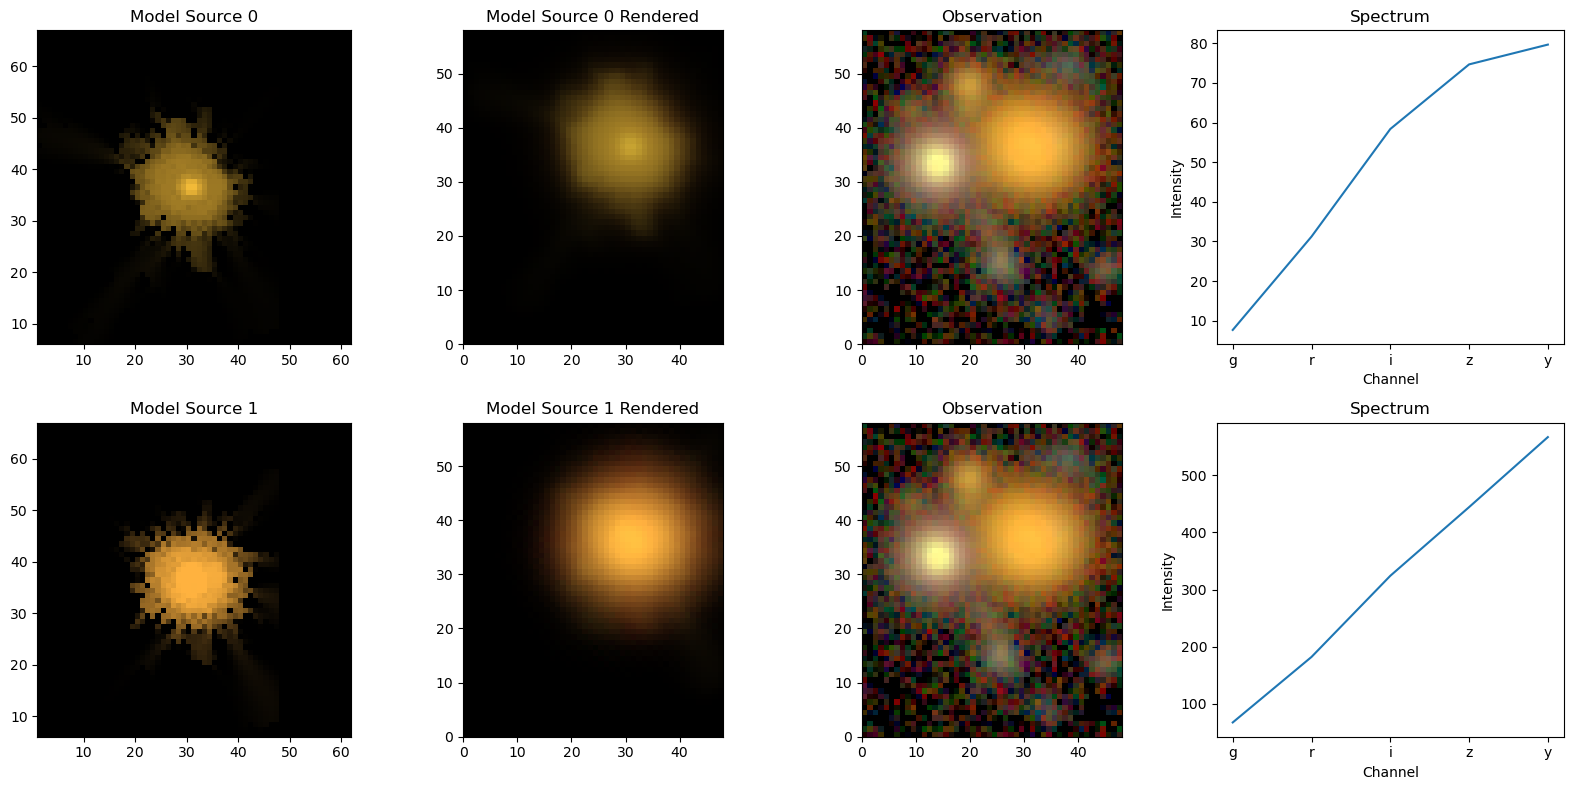

In [8]:
scarlet.display.show_sources(sources[1], 
                             norm=norm, 
                             channel_map=channel_map,
                             observation=observation,
                             show_rendered=True, 
                             show_observed=True,
                             add_markers=True,
                            )
plt.show()